# OOD Detection on the MNIST and Fashion-MNIST Dataset

## Introduction

First we import the necessary libraries.

In [23]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torchvision.models import resnet18

Load the MNIST dataset and create a subsample of the dataset.

In [24]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load MNIST dataset
mnist = datasets.MNIST(root='.', download=True, transform=transforms.ToTensor())

# Create a subsample of the dataset
subsample_size = 10000  # specify your subsample size here
indices = torch.randperm(len(mnist))[:subsample_size]
subsample = torch.utils.data.Subset(mnist, indices)

# Split the subsample into train and test
train_size = int(0.8 * len(subsample))  # 80% for training
test_size = len(subsample) - train_size
print(f"Train size: {train_size}, Test size: {test_size}")
train_dataset, test_dataset = random_split(subsample, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=test_size)

# Compute the average prevalence of each class in the training set
train_labels = np.array([label for _, label in train_dataset])
print("Unique labels in the training set: ", np.unique(train_labels))
ref_distri = np.bincount(np.array(train_labels)) / len(train_labels)
print(f"Average prevalence of each class in the training set: {ref_distri}")

Train size: 8000, Test size: 2000
Unique labels in the training set:  [0 1 2 3 4 5 6 7 8 9]
Average prevalence of each class in the training set: [0.099625 0.107875 0.1015   0.10375  0.099375 0.090125 0.096375 0.104375
 0.098    0.099   ]


In [25]:
# model class
class CNN_DigitClassifier(nn.Module):
  def __init__(self, num_classes=10):
    super(CNN_DigitClassifier, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, num_classes)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return x
  
  def predict_proba(self, x):
    x = self.forward(x)
    return F.softmax(x, dim=1)

In [26]:
# Define temperature scaled softmax function and energy-based softmax function
def temperature_scaled_softmax(logits, temperature=1.0):
    return F.softmax(logits / temperature, dim=0)


def energy_function(logits, temperature=1.0):
    scaled_logits = logits / temperature
    exp_terms = np.exp(scaled_logits)
    sum_exp_terms = exp_terms.sum()
    energy = -temperature * np.log(sum_exp_terms)
    return energy

Train the model on the MNIST dataset K=5 folds. For each fold, we train the model on K-1 folds and validate on the remaining fold. On the remaining fold we compute the OOD measures. 

In [27]:
from copy import deepcopy
from utils.OOD_classification import tv_div
from scipy.stats import entropy
from scipy.stats import wasserstein_distance as wass_dist
from scipy.stats import entropy as kl_div
from scipy.spatial.distance import jensenshannon as js_dist

num_epochs = 10

alpha_dict = {0.1: [], 0.05: [], 0.01: []}
th_dict = {'max_softmax': deepcopy(alpha_dict), 'ODIN': deepcopy(alpha_dict),
           'energy': deepcopy(alpha_dict),
           'entropy': deepcopy(alpha_dict), 'kl_div': deepcopy(alpha_dict), 
           'js_div': deepcopy(alpha_dict), 'wass_dist': deepcopy(alpha_dict)}

# K folds loop
K = 10
for fold in range(K):
    
    print(f'Fold {fold+1}/{K}')
        
    # Initialize the model
    model = CNN_DigitClassifier(num_classes=10)
    
    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Split the subsample into train and test
    train_size = int(0.8 * len(subsample))  # 80% for training
    test_size = len(subsample) - train_size
    train_dataset, test_dataset = random_split(subsample, [train_size, test_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Training loop
    for epoch in range(num_epochs):  # number of epochs
        for images, labels in train_loader:            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # Initialize the statistics
    max_softmax_, odin_, energy_ = [], [], []
    entropy_, kl_div_, js_div_, wass_dist_ = [], [], [], []
    
    # Compute OOD measures
    for images, labels in test_loader:
        
        # Forward pass
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1).detach().numpy()
        
        # Loop over each sample in the batch
        for i in range(probabilities.shape[0]):
            
            # Flatten out the logits
            out_i = outputs[i].detach().numpy()
            temp_scaled_i = temperature_scaled_softmax(torch.tensor(out_i)).detach().numpy()

            # Compute OOD measures
            max_softmax_.append(np.max(probabilities[i]))
            odin_.append(np.max(temp_scaled_i))
            energy_.append(energy_function(out_i))
            entropy_.append(entropy(probabilities[i], base=2))
            kl_div_.append(kl_div(probabilities[i], ref_distri))
            js_div_.append(js_dist(probabilities[i], ref_distri, base=2))
            wass_dist_.append(wass_dist(probabilities[i], ref_distri))
            # wass_dist_.append(wass_dist(u_weights=probabilities[i], v_weights=ref_distri,
            #                             u_values=np.arange(10), v_values=np.arange(10)))
        
    max_softmax_, odin_, energy_ = np.stack(max_softmax_), np.stack(odin_), np.stack(energy_)
    entropy_, kl_div_, js_div_, wass_dist_ = np.stack(entropy_), np.stack(kl_div_), np.stack(js_div_), np.stack(wass_dist_)
    
    # Compute the thresholds as the \alpha quantile of the statistics and populate the th_dict
    for alpha in [0.1, 0.05, 0.01]:
        th_dict['max_softmax'][alpha].append(np.quantile(max_softmax_, alpha))
        th_dict['ODIN'][alpha].append(np.quantile(odin_, alpha))
        th_dict['energy'][alpha].append(np.quantile(energy_, 1-alpha))
        th_dict['entropy'][alpha].append(np.quantile(entropy_, 1 - alpha))
        th_dict['kl_div'][alpha].append(np.quantile(kl_div_, alpha))
        th_dict['js_div'][alpha].append(np.quantile(js_div_, alpha))
        th_dict['wass_dist'][alpha].append(np.quantile(wass_dist_, alpha))


Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


In [28]:
# After the K folds, compute the thresholds as the 0.95 quantile of the statistics across the folds
for alpha in [0.1, 0.05, 0.01]:
    th_dict['max_softmax'][alpha] = np.quantile(th_dict['max_softmax'][alpha], 0.5)
    th_dict['ODIN'][alpha] = np.quantile(th_dict['ODIN'][alpha], 0.5)
    th_dict['energy'][alpha] = np.quantile(th_dict['energy'][alpha], 0.5)
    th_dict['entropy'][alpha] = np.quantile(th_dict['entropy'][alpha], 0.5)
    th_dict['kl_div'][alpha] = np.quantile(th_dict['kl_div'][alpha], 0.5)
    th_dict['js_div'][alpha] = np.quantile(th_dict['js_div'][alpha], 0.5)
    th_dict['wass_dist'][alpha] = np.quantile(th_dict['wass_dist'][alpha], 0.5)
    
print(th_dict)

{'max_softmax': {0.1: 0.6430807560682297, 0.05: 0.5187933012843132, 0.01: 0.36076192051172257}, 'ODIN': {0.1: 0.6430807560682297, 0.05: 0.5187933012843132, 0.01: 0.36076192051172257}, 'energy': {0.1: -4.31900017261505, 0.05: -3.504056334495545, 0.01: -2.4787406897544866}, 'entropy': {0.1: 1.2669956600596601, 0.05: 1.6408242399598423, 0.01: 2.382397876369329}, 'kl_div': {0.1: 1.4369584076296504, 0.05: 1.1664271037543448, 0.01: 0.6429470467609982}, 'js_div': {0.1: 0.7119558249441547, 0.05: 0.6497978456941406, 0.01: 0.49382912989787475}, 'wass_dist': {0.1: 0.13844674790121334, 0.05: 0.125616199892377, 0.01: 0.09142819835990759}}


## 2) OOD as Fashion-MNIST

We now upload as test dataset 50% of the existing MNIST dataset and 50% of the Fashion-MNIST dataset, and treat it as OOD. We will use the thresholds computed on the MNIST dataset to detect OOD samples in the Fashion-MNIST dataset.

In [29]:
# Set seed for reproducibility
torch.manual_seed(13)

# Load Fashion-MNIST dataset
fashion_mnist = datasets.FashionMNIST(root='.', download=True, transform=transforms.ToTensor())

# Create a subsample of the dataset
subsample_size = 1000
indices = torch.randperm(len(fashion_mnist))[:subsample_size]
fash_mnist_subsample = torch.utils.data.Subset(fashion_mnist, indices)
print("Number of OOD samples in the Fashion-MNIST subsample: ", len(fash_mnist_subsample))

# Select 200 of the MNIST dataset as ID
mnist = datasets.MNIST(root='.', download=True, transform=transforms.ToTensor())
indices = torch.randperm(len(mnist))[:subsample_size]
mnist_subsample = torch.utils.data.Subset(mnist, indices)
print("Number of ID samples in the MNIST subsample: ", len(mnist_subsample))

Number of OOD samples in the Fashion-MNIST subsample:  1000
Number of ID samples in the MNIST subsample:  1000


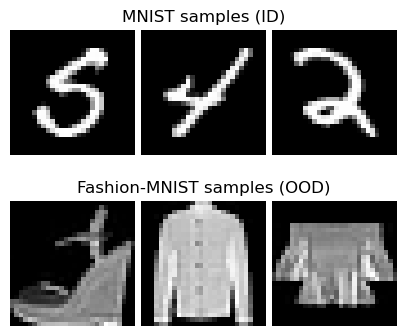

In [30]:
# Plot in 3x3 grid the first 9 images of the MNIST subsample on one side and the Fashion-MNIST subsample on the other side
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(5, 5))
# Reduce space in between subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.2)
for j in range(3):
    axs[0, j].imshow(mnist_subsample[j][0].squeeze(), cmap='gray')
    axs[0, j].axis('off')
# Title of the plot for MNIST samples
axs[0, 1].set_title('MNIST samples (ID)')

for j in range(3):
    axs[1, j].imshow(fash_mnist_subsample[j][0].squeeze(), cmap='gray')
    axs[1, j].axis('off')
axs[1, 1].set_title('Fashion-MNIST samples (OOD)')
# Save the figure
plt.savefig('images/Fashion_MNIST_samples.pdf')

In [31]:
# Now we create the test dataset by stacking together the MNIST and Fashion-MNIST subsamples and
# create the corresponding labels: 0 for MNIST (ID) and 1 for Fashion-MNIST (OOD)
test_dataset = torch.utils.data.ConcatDataset([mnist_subsample, fash_mnist_subsample])
test_loader = DataLoader(test_dataset, batch_size=subsample_size*2)
OOD_labels = np.concatenate([np.zeros(subsample_size), np.ones(subsample_size)])

In [32]:

OOD_pred = {'max_softmax': [], 'ODIN': [], 'energy': [], 
            'entropy': [], 'kl_div': [], 'js_div': [], 'wass_dist': []}
# Compute OOD measures
for images, labels in test_loader:
    
    # Forward pass
    outputs = model(images)
    probabilities = F.softmax(outputs, dim=1).detach().numpy()
    
    # Print the average of max probabilities on the ID and OOD datasets
    print(f'Average max probability on ID dataset: {np.max(probabilities[:subsample_size], axis=1).mean()}')
    print(f'Average max probability on OOD dataset: {np.max(probabilities[subsample_size:], axis=1).mean()}')
    
    
    # Loop over each sample in the batch
    for i in range(probabilities.shape[0]):
        
        out_i = outputs[i].detach().numpy()
        temp_scaled_i = temperature_scaled_softmax(torch.tensor(out_i)).detach().numpy()
        
        # Compute OOD measures
        max_softmax_i = np.max(probabilities[i])
        odin_i = np.max(temperature_scaled_softmax(torch.tensor(out_i)).detach().numpy())
        energy_i = energy_function(out_i)
        entropy_i = entropy(probabilities[i], base=2)
        kl_div_i = kl_div(probabilities[i], ref_distri)
        js_div_i = js_dist(probabilities[i], ref_distri, base=2)
        wass_dist_i = wass_dist(probabilities[i], ref_distri)
        # wass_dist_i = wass_dist(u_weights=probabilities[i], v_weights=ref_distri,
        #                         u_values=np.arange(10), v_values=np.arange(10))
        
        # Append the predictions
        OOD_pred['max_softmax'].append(max_softmax_i < th_dict['max_softmax'][0.05])
        OOD_pred['ODIN'].append(odin_i < th_dict['ODIN'][0.05])
        OOD_pred['energy'].append(energy_i > th_dict['energy'][0.05])
        OOD_pred['entropy'].append(entropy_i > th_dict['entropy'][0.05])
        OOD_pred['kl_div'].append(kl_div_i < th_dict['kl_div'][0.05])
        OOD_pred['js_div'].append(js_div_i < th_dict['js_div'][0.05])
        OOD_pred['wass_dist'].append(wass_dist_i < th_dict['wass_dist'][0.05])
        
# Convert to numpy array
for key in OOD_pred.keys():
    OOD_pred[key] = np.stack(OOD_pred[key])
    # print(f'{key}: {OOD_pred[key]}')
                    

Average max probability on ID dataset: 0.9114812016487122
Average max probability on OOD dataset: 0.4742242097854614


In [34]:
# Compute the AUROC, TPR, FPR for each OOD measure
from sklearn.metrics import roc_auc_score, confusion_matrix

for key in OOD_pred.keys():
    print(f'{key}:')
    print(f'AUROC: {roc_auc_score(OOD_labels, OOD_pred[key]).__round__(5)}')
    tn, fp, fn, tp = confusion_matrix(OOD_labels, OOD_pred[key]).ravel()
    print(f'TPR: {(tp / (tp + fn)).__round__(5)}')
    print(f'FPR: {(fp / (fp + tn)).__round__(5)}')
    print()

max_softmax:
AUROC: 0.7995
TPR: 0.639
FPR: 0.04

ODIN:
AUROC: 0.7995
TPR: 0.639
FPR: 0.04

energy:
AUROC: 0.886
TPR: 0.844
FPR: 0.072

entropy:
AUROC: 0.849
TPR: 0.754
FPR: 0.056

kl_div:
AUROC: 0.8455
TPR: 0.748
FPR: 0.057

js_div:
AUROC: 0.8685
TPR: 0.793
FPR: 0.056

wass_dist:
AUROC: 0.853
TPR: 0.758
FPR: 0.052


## Conclusion
